In [1]:
import numpy as np
import matplotlib.pyplot as plt
import george
from george import kernels

# Week 10, ASTR 496: Foundations of Data Science in Astronomy

## Hierarchical Bayes and Modeling Populations 

### Gautham Narayan 
##### <gsn@illinois.edu>

## Recap

Last week, we saw how:

1. A Gaussian process is specified by a choice for mean and covariance kernel
2. For a fixed choice of mean and covariance kernel, but no data, you have a Gaussian process prior - an infinite number of functions can be drawn from this prior

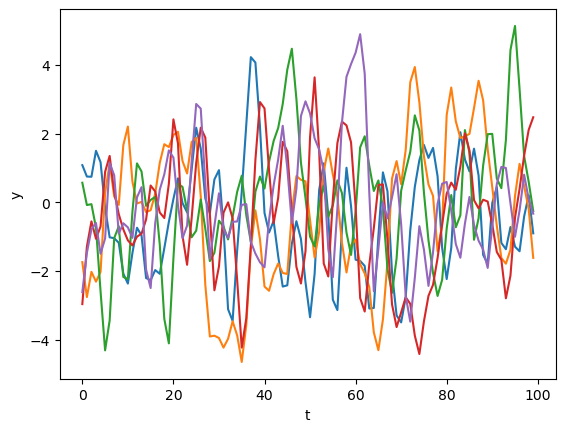

In [2]:
# Create a kernel 
k = 3*kernels.ExpSquaredKernel(metric=2.)

# Define a Gaussian Process - you need a mean and a kernel 
gp = george.GP(mean=0, kernel=k)

# Evaluate the kernel on the abscissa values/exogenous variable/x/t
t = np.arange(0, 100)
gp.compute(t)

# draw some random samples from the Gaussian process prior
samples = gp.sample(t, size=5)

# and plot them
plt.figure()
plt.plot(t, samples.T)
plt.xlabel('t')
plt.ylabel('y');

## Recap

3. This framework is really flexible, and you can use it to make predictions for physical processes even when you can't write down an explicit model 

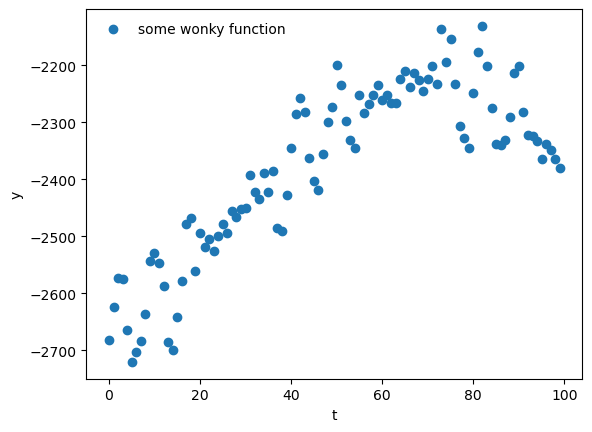

In [3]:
# Define some function of the exogenous variable
def func(t):
    ''' 
    some completely whacky function that we might never imagine to write down as a model
    '''
    np.random.seed(42)
    y = - 3*((t/20)-30)**2 - 0.001*(t-20)**3 + 20*np.random.randn(len(t))
    ind = ((t/18)%2)<=1
    y[ind] += 90*np.sin(np.pi/4*t[ind] )
    return y

# evaluate the function at abscissa values
y = func(t)


# and plot them
plt.figure()
plt.scatter(t, y, marker='o', label='some wonky function')
plt.legend(frameon=False)
plt.xlabel('t')
plt.ylabel('y');

## Recap

4. You have to condition the model on the data (i.e. evaluate the posterior) if you want to make predictions (either interpolating or extrapolating)

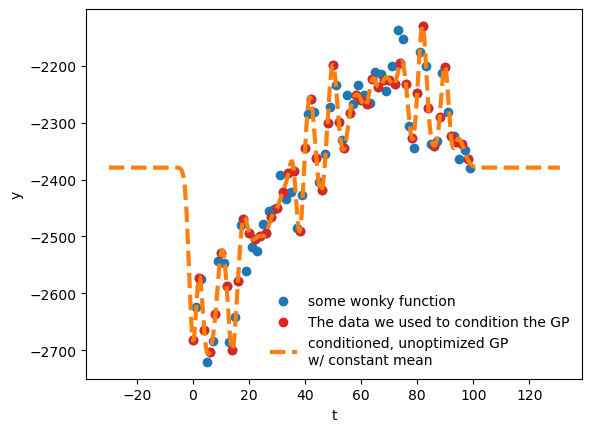

In [4]:
# Define a GP with the same kernel as before, but a mean specified by the mean of the data
gp = george.GP(mean=np.mean(y), kernel=k)


# again, evaluate the kernel at the abscissa values - we'll only use every other value
gp.compute(t[::2])

# setup a new array of times for prediction
t_new = np.arange(-30, 131, 0.1)

plt.figure()
# now *CONDITION* the GP on the observed values y, and predict on the new values t_new
ypred1 = gp.predict(y[::2], t_new, return_cov=False)

# and plot the original data + the GP prediction with the constant mean
plt.scatter(t, y, color='C0', marker='o', label='some wonky function')
plt.scatter(t[::2], y[::2], color='C3', marker='o', label='The data we used to condition the GP')

plt.plot(t_new, ypred1, 'C1', ls='--', label='conditioned, unoptimized GP\nw/ constant mean', lw=3)
plt.legend(frameon=False)
plt.xlabel('t')
plt.ylabel('y'); 

## Recap

5. If you want your predictions to be reasonable, you should think about how to specify the mean function well.
    
Advice: Use the mean function to specify the things that can you model reasonably, and use the Gaussian process to describe the bit you cannot. 

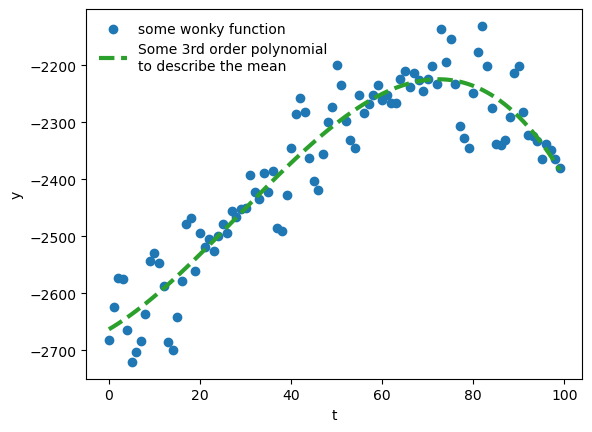

In [5]:
# maybe we can't write down a model, but we can say looking a the data that there is some polynomial trend
coeffs = np.polyfit(t, y, 3)
plt.figure()
# plot the data with the fitted polynomial
plt.scatter(t, y, color='C0', marker='o', label='some wonky function')
plt.plot(t, np.polyval(coeffs, t), color='C2', ls='--', label='Some 3rd order polynomial\nto describe the mean', lw=3)
plt.legend(frameon=False)
plt.xlabel('t')
plt.ylabel('y');

In [6]:
import scipy.optimize as op
from george.modeling import Model

# define a mean model defined by the polynomial we just found
class PolynomialModel(Model):
    parameter_names = ()
    global coeffs
    def get_value(self, t):
        t = t.flatten()
        return (np.polyval(coeffs, t))

    
# now use the polynomial as the mean model - but we're not fitting those values again - just the GP parameters
gp = george.GP(mean=PolynomialModel(), kernel=k)


# Define the objective function (negative log-likelihood in this case).
def nll(p):
    gp.set_parameter_vector(p)
    ll = gp.log_likelihood(y[::2], quiet=True)
    return -ll if np.isfinite(ll) else 1e25

# And the gradient of the objective function.
def grad_nll(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y[::2], quiet=True)

# You need to compute the GP once before starting the optimization.
gp.compute(t[::2])

# Run the optimization routine.
p0 = gp.get_parameter_vector()
results = op.minimize(nll, p0, jac=grad_nll, method="L-BFGS-B")

# Update the kernel and print the final log-likelihood.
gp.set_parameter_vector(results.x)

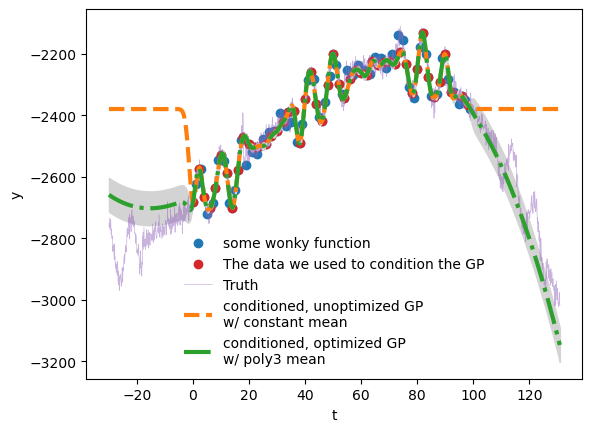

In [7]:
# now make a new prediction with our new mean model
ypred2, cov = gp.predict(y[::2], t_new, return_cov=True)
std = np.sqrt(np.diag(cov))

plt.figure()

# plot the data
plt.scatter(t, y, color='C0', marker='o', label='some wonky function')
plt.scatter(t[::2], y[::2], color='C3', marker='o', label='The data we used to condition the GP')

# and plot the truth
plt.plot(t_new, func(t_new), 'C4', ls='-', lw=0.5, label='Truth', alpha=0.5)

# plot our initial prediction with a constant mean
plt.plot(t_new, ypred1, 'C1', ls='--', label='conditioned, unoptimized GP\nw/ constant mean', lw=3)

# plot our new prediction with the polynomial mean 
plt.plot(t_new, ypred2, 'C2', ls='-.', label='conditioned, optimized GP\nw/ poly3 mean', lw=3)

# plot the scatter about the posterior predictive mean from the diagonal of the covariance matrix 
plt.fill_between(t_new, ypred2-std, ypred2+std, color='lightgrey')


plt.legend(frameon=False)
plt.xlabel('t')
plt.ylabel('y');

## Recap



The "ExpSquared" (Squared Exponential) kernel we used above is:

\begin{equation}
k_{1}\left(t, t^{\prime}\right)=\theta_{1}^{2} \exp \left(-\frac{\left(t-t^{\prime}\right)^{2}}{2 \theta_{2}^{2}}\right)
\end{equation}


If, for a specific set of values for $\theta_{1},\theta_{2}$ in your chosen kernel, your Gaussian process prior corresponds to a family of functions, and you are not sure of the values of $\theta_{1},\theta_{2}$ itself, then you can imagine $\theta_{1},\theta_{2}$ to be parameters themselves.

### These are parameters of a prior distribution - we call these **hyperparameters** 

## How we pick priors:

1. If we have a previous/independent measurement/inference of the parameter etc., use it with its error bars as $p(\theta)$. (You've done this)

2. Choose wide, uninformative distributions for all the parameters we don’t know well. (You've done this)

3. **Use distributions in nature from previous observations of similar objects i.e. the population.**

## Option 3: Use distributions in nature from previous observations of similar objects.


Histograms of population properties, when normalized, can be interpreted as probability distributions for individual parameters:


## $$
\mathbf{p}(\theta)=\mathbf{n}(\theta | \mathbf{\alpha}) / \int \mathbf{n}(\theta | \mathbf{\alpha}) \mathbf{d} \mathbf{\theta}=\mathbf{p}(\theta | \mathbf{\alpha})
$$


where $n(\theta|\alpha)$ is the function with parameters $\alpha$ that was fit to the histogram

$\theta$ = parameter

$\alpha$ = hyperparameter

## Going Hierarchical:

Bayes theorem:

## $$ p(\theta|x) = p(x|\theta)\cdot p(\theta) $$

Abstracting:
## $$\Bigg\downarrow$$

## $$ p(\theta|x) = p(x|\theta)\cdot p(\theta | \alpha) $$

i.e. the population helps make inference on individual ... 

# What is this hierarchical Bayesian framework good for?

### If you have multiple sets of measurements, each of which are related, we may want to learn something not just about each individual measurement, *but also the population*

In quantitative psychology for example you test multiple subjects on the same task. We then want to estimate a computational/mathematical model that describes the behavior on the task by a set of parameters. 

- We could thus fit a model to each subject individually, assuming they share no similarities; 
- or, pool all the data and estimate one model assuming all subjects are identical

<img src="tacos.jpg">

**Hierarchical modeling** allows the best of both worlds by modeling subjects’ similarities but also allowing estimiation of individual parameters.

In elections, everyone is looking at the same ballot nationally, and we care about the overall population, but maybe we also care about how states/counties differ from each other.

The same is true of countries during a global pandemic...

E.g. your midterm - you have multiple galaxies, each with a potentially indpendent period-luminosity relation (indeed many of you treated it as such) because they have different ages/star formation history/whatever.

Maybe you are interested in the P-L relation for just 1 galaxy, but maybe you also care about the population of all of them so you can derive the Hubble constant.

I didnd't have you do that for the slopes, but I did for the intercepts. 

## Going Hierarchical: Inferring properties of a population

... but what if we want to use the individuals to infer things (the $\alpha$’s) about the population?

i.e., **$p(\theta|\alpha)$ contains interesting physics and getting values for $\alpha$ given the data (individuals) can help us understand the population**

## $$ p(\theta|x) = p(x|\theta)\cdot p(\theta | \alpha) $$

## $$\Bigg\downarrow$$

## $$ p(\alpha, \theta|x) = p(x|\theta)\cdot p(\theta | \alpha) \cdot p(\alpha)$$

For your midterm, where we could have fit individual slopes $\theta_i$ we did the extreme thing of $p(\theta_i | \alpha) = \delta(\theta_i - \alpha)$ and fit just one global slope $\alpha$

<img src="hierarchical1.png">

<img src="hierarchical2.png">

## Build up complexity by layering conditional probabilities

## And if you really don't care the parameters for individual measurements, just marginalize over them

## $$
p(\alpha |x) \propto\left[\int p(x | \theta, \alpha) p(\theta | \alpha) d\theta\right] p(\alpha)=p(x | \alpha) p(\alpha)
$$

(This is what happens with your Gaussian Process)

## Hierarchical modeling is a statistically rigorous way  to make scientific inferences about a population (or specific object) based on many individuals (or observations).

<img src="hbm1.png">

courtesy: Tom Loredo

<img src="hbm2.png">

courtesy: Tom Loredo

# WHY does this work??

- All 18 players are humans playing baseball—they are members of a population, not arbitrary, unrelated binomial random number generators!

- In the absence of data about player $i$, we may use the performance of the other players to guide a guess about that player’s performance—they provide indirect evidence about player $i$

- But information that is relevant in the absence of data for $i$ remains relevant when we additionally obtain that data; shrinkage estimators account for this

- There is “mustering and borrowing of strength” (Tukey) across the population

- Hierarchical Bayesian modeling is the most flexible framework for generalizing this lesson

## There's many examples of situations where we care about populations:

<img src="kepler_mass_radius.png">

[Kepler Planets from Lissauer, Dawson and Tremaine, 2014](https://ui.adsabs.harvard.edu/abs/2014Natur.513..336L/abstract)


### Once we discover an object, we look for more to characterize their properties and understand their origin.

### Or maybe we use many noisy observations of a single object to understand it's physics.

<table style="width:100%">
  <tr>
    <th><img src="SN1987A_R.jpg"></th>
  </tr>
  <tr>
    <th><img src="SN1987A_B.jpg"></th>
  </tr>
</table> 

[Larrson et al., 2019](https://ui.adsabs.harvard.edu/abs/2019ApJ...886..147L/abstract)

<img src="hierarchical3.png">
Courtesy: Angie Wolfgang

<img src="hierarchical4.png">
Courtesy: Angie Wolfgang

<img src="hierarchical5.png">
Courtesy: Angie Wolfgang

<img src="hierarchical6.png">
Courtesy: Angie Wolfgang

<img src="hierarchical7.png">

Courtesy: Angie Wolfgang

So let's look at a few different approaches to the midterm:



<table>
    <col width="300">
    <col width="300">
    <col width="300">
    <tr>
        <td>
            One Observation of one Cepehid (Use PSF fitting to get photometry):
            <img src="HubbleVar.png">
        </td>
        <td>
            One Cepheid (Use Periodogram/GP to get period):
            <img src="Cepheid-variabledb92-600x461.jpg">
        </td>
        <td>
            Many Cepheids in one galaxy (Use MLE to get slope and intercept of PL relation):
            <img src="cepheid_data.png">
        </td>
    </tr>  
</table>

## Recap: PGM for Many Cepehids in One Galaxy

Many Cepheids in one galaxy.


<img src="pgms_cepheids.png">


**This is a multi-level model**

When we first saw this back in week 3, we weren't even Bayesian and didn't worry about things like priors, let alone hyper priors.

## Recap: PGM for many Cepheids in many galaxies

This is what the midterm question prompted:

<img src="keygals.jpg">

[Daft](https://docs.daft-pgm.org/en/latest/) is a package to draft probabilistic graphical models

```
conda install daft-pgm
```

In [8]:
import daft

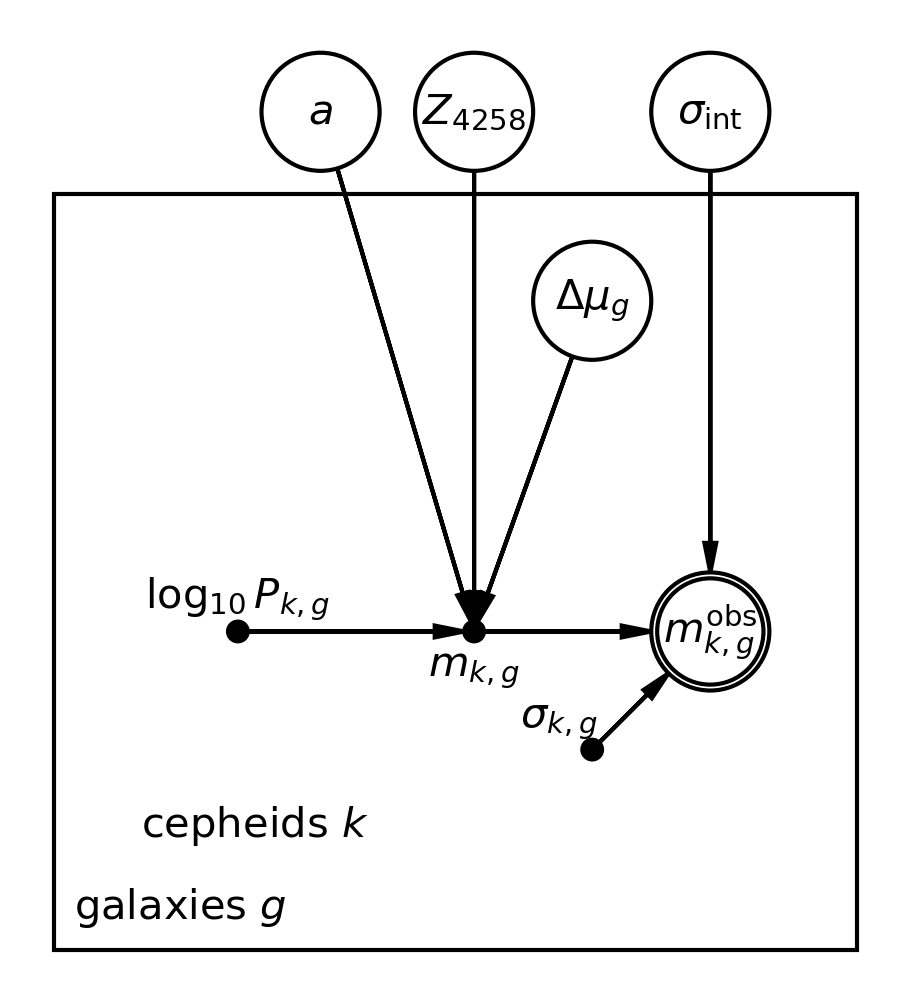

In [9]:
pgm = daft.PGM(observed_style="inner", dpi=300)
pgm.add_node("P", r'$\log_{10} P_{k,g}$', x=0, y=0, fixed=True)
pgm.add_node("m", r'$ m_{k,g}$', x=1, y=0, fixed=True, offset=(0, -16))
pgm.add_node("sig", r'$\sigma_{k,g}$', x=1.5, y=-0.5, fixed=True, offset=(-8,0))
pgm.add_node("dmu", r'$\Delta \mu_g$', x=1.5, y=1.4)
pgm.add_node('mobs', r'$m_{k,g}^{\mathrm{obs}}$', x=2, y=0, observed=True)
pgm.add_node("sigint", r'$\sigma_{\mathrm{int}}$', x=2, y=2.2)
pgm.add_node("Z", r'$Z_{4258}$', x=1, y=2.2)
pgm.add_node("a", r'$a$', x=0.35, y=2.2)

pgm.add_edge("P", "m")
pgm.add_edge("m", "mobs")
pgm.add_edge("sig", "mobs")
pgm.add_edge("dmu", "m")
pgm.add_edge('Z',"m")
pgm.add_edge("a", "m")
pgm.add_edge("sigint", "mobs" )

pgm.add_plate([-0.5, -1, 3, 2], "cepheids $k$", )
pgm.add_plate([-0.78, -1.35, 3.4, 3.2], "galaxies $g$", )
pgm.render();

## This model subtly had a population parameter and individual parameters $Z_{4258}$ and $\Delta\mu_g$

## This choice of parameterization was good 

## We only cared about the population parameter $Z_{4258}$ and could regard the $\Delta\mu$'s as nuisance parameters


# $$
\log H_{0}= \sum_{g} \frac{\left(m_{v, g}^{0}+5 a_{v}\right)-\left(\Delta \mu_{g}+Z_{4258}\right)+25}{5}
$$

(That's what the sum over $g$ is - marginalizing over all the galaxies)

## But we also forced all the cepheids in all the galaxies to obey the exact same P-L relation


## That's a modeling choice, but it may not be a very good one

<img src="all_gals.png">

## Yet, visibly, the cepehids do not all have vastly different slopes...


## So what we if we treated the P-L relation as a population parameter, but allowed each galaxy to vary a little?

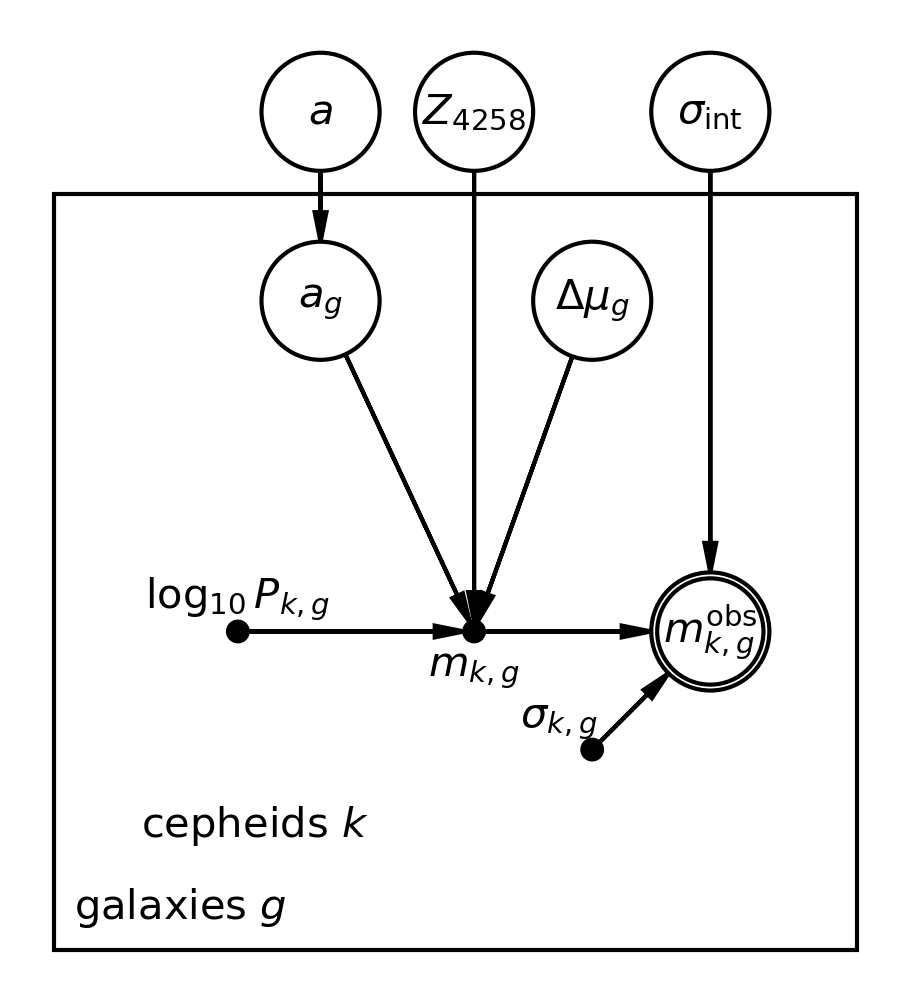

In [10]:
pgm = daft.PGM(observed_style="inner", dpi=300)
pgm.add_node("P", r'$\log_{10} P_{k,g}$', x=0, y=0, fixed=True)
pgm.add_node("m", r'$ m_{k,g}$', x=1, y=0, fixed=True, offset=(0, -16))
pgm.add_node("sig", r'$\sigma_{k,g}$', x=1.5, y=-0.5, fixed=True, offset=(-8,0))
pgm.add_node("dmu", r'$\Delta \mu_g$', x=1.5, y=1.4)
pgm.add_node('mobs', r'$m_{k,g}^{\mathrm{obs}}$', x=2, y=0, observed=True)
pgm.add_node("sigint", r'$\sigma_{\mathrm{int}}$', x=2, y=2.2)
pgm.add_node("Z", r'$Z_{4258}$', x=1, y=2.2)
pgm.add_node("a", r'$a$', x=0.35, y=2.2)
pgm.add_node("a_g", r'$a_g$', x=0.35, y=1.4)

pgm.add_edge("P", "m")
pgm.add_edge("m", "mobs")
pgm.add_edge("sig", "mobs")
pgm.add_edge("dmu", "m")
pgm.add_edge('Z',"m")
pgm.add_edge("a", "a_g")
pgm.add_edge("a_g", "m")
pgm.add_edge("sigint", "mobs" )

pgm.add_plate([-0.5, -1, 3, 2], "cepheids $k$", )
pgm.add_plate([-0.78, -1.35, 3.4, 3.2], "galaxies $g$", )
pgm.render();